In [1]:
import jax.numpy as np
import numpy as onp
from NODE_fns import NODE as NODE
from jax import grad, random, jit, vmap#, partial
from functools import partial
from jax.experimental import optimizers
import pickle
import time
import matplotlib.pyplot as plt
key = random.PRNGKey(0)

/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
with open('saved/params_jax.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/norm_w_jax.npy', 'rb') as f:
    inp_mean, inp_stdv, out_mean, out_stdv = pickle.load(f)

In [3]:
def dphidtaui_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]
    
def dPhi(params, tau1, tau2, tau3):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params

    tau1 = (tau1 - inp_mean)/inp_stdv
    tau2 = (tau2 - inp_mean)/inp_stdv
    tau3 = (tau3 - inp_mean)/inp_stdv


    N1 = NODE(tau1, NODE1_params)
    N2 = NODE(tau1 + tau2, NODE2_params)
    N3 = NODE(tau1 + tau2 + tau3, NODE3_params)
    N4 = NODE(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params)
    N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params)

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    Phi1 = Phi1*out_stdv + out_mean
    Phi2 = Phi2*out_stdv + out_mean
    Phi3 = Phi3*out_stdv + out_mean
    return Phi1, Phi2, Phi3
dPhi_vmap = vmap(dPhi, in_axes=(None, 0, 0, 0), out_axes = (0, 0, 0))

In [6]:
n = 1000
taui = onp.random.normal(size=[n,3])*10000
taui = -onp.sort(-taui) #Sort taui in descending order
dphidtaui = onp.zeros_like(taui)
for i in range(n):
    dphidtaui[i] = dphidtaui_gov(taui[i])

dphidtaui = dphidtaui.transpose()
dphidtaui_pr = dPhi_vmap(params, taui[:,0], taui[:,1], taui[:,2])
dphidtaui_pr = onp.array(dphidtaui_pr)

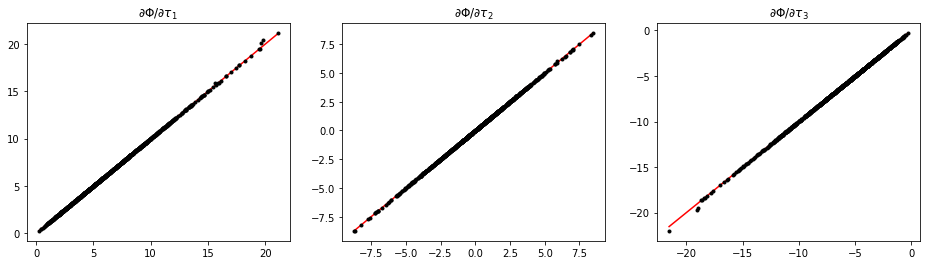

In [7]:
fig,ax = plt.subplots(1,3, figsize=[16,4])
names = [1,2,3]
for i in range(3):
    mx = onp.max(dphidtaui[i])
    mn = onp.min(dphidtaui[i])
    ax[i].plot([mn, mx], [mn, mx], 'r')
    ax[i].plot(dphidtaui[i], dphidtaui_pr[i], 'k.')
    ax[i].set(title='$\\partial \\Phi / \\partial \\tau_{{ {s} }}$'.format(s = names[i]))
    # ax[i].set(xlim=[mn, mx], ylim=[mn, mx])